In [ ]:
! pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [ ]:
import torch
import segmentation_models_pytorch as smp
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# needed for plotting confusion matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from __future__ import print_function, division

from sklearn.metrics import confusion_matrix as sk_confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
!unzip -qq '/content/drive/My Drive/CT_Scan_Brazil-20200621T154301Z-001.zip'

In [ ]:
# Load Data
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/CT_Scan_Brazil'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
print(class_names)
print(dataloaders)
print(dataset_sizes)

['Covid', 'Non_Covid']
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f8291fd58d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f8291fd5f98>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f8291f8c048>}
{'train': 1736, 'val': 496, 'test': 249}


In [ ]:
# needed for unet
aux_params=dict(
    pooling='avg',             # one of 'avg', 'max'
    dropout=0.5,               # dropout ratio, default is None
    activation='sigmoid',      # activation function, default is None
    classes=2,                 # define number of output labels
)

In [ ]:
# Training the model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    # best_acc = 0.0

    train_acc_values = [] # for plotting purpose
    val_acc_values = [] # for plotting purpose

    best_acc_test = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        # for phase in ['train', 'val','test']:
        for phase in ['train', 'test']: # test is validation now as it contains 10% data
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # outputs = model(inputs)
                    mask, outputs = model(inputs) # Unet
                    _,preds = torch.max(outputs, 1)

                    # print(preds[0]) # unet test
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
              train_acc_values.append(epoch_acc)
            if phase == 'test':
              val_acc_values.append(epoch_acc) # test is validation now as it contains 10% data

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            # if phase == 'val' and epoch_acc > best_acc:
            #     best_acc = epoch_acc
            #     best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase == 'test' and epoch_acc > best_acc_test:
                best_acc_test = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    # print('Best val Acc: {:4f}'.format(best_acc))

    print('Best val Acc: {:4f}'.format(best_acc_test))  # test is validation now as it contains 10% data

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), '/content/drive/My Drive/covid_models/res_50.pt') # save model
    return model , train_acc_values , val_acc_values

In [ ]:
# Unet
model_ft = smp.Unet('resnet50', classes=2, encoder_weights='imagenet',aux_params=aux_params)
# print(model_ft)

In [ ]:
# Unet
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# Unet
model_ft , train_acc_values , val_acc_values = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5686 Acc: 0.7339
test Loss: 0.5332 Acc: 0.7711

Epoch 1/24
----------
train Loss: 0.4909 Acc: 0.8180
test Loss: 0.6303 Acc: 0.6747

Epoch 2/24
----------
train Loss: 0.4732 Acc: 0.8318
test Loss: 0.7518 Acc: 0.5582

Epoch 3/24
----------
train Loss: 0.4722 Acc: 0.8341
test Loss: 0.7016 Acc: 0.5863

Epoch 4/24
----------
train Loss: 0.4699 Acc: 0.8393
test Loss: 0.5896 Acc: 0.7229

Epoch 5/24
----------
train Loss: 0.4763 Acc: 0.8324
test Loss: 0.7017 Acc: 0.5863

Epoch 6/24
----------
train Loss: 0.4671 Acc: 0.8364
test Loss: 0.7594 Acc: 0.5221

Epoch 7/24
----------
train Loss: 0.4575 Acc: 0.8548
test Loss: 0.6691 Acc: 0.6145

Epoch 8/24
----------
train Loss: 0.4618 Acc: 0.8474
test Loss: 0.6895 Acc: 0.5904

Epoch 9/24
----------
train Loss: 0.4343 Acc: 0.8738
test Loss: 0.6994 Acc: 0.5743

Epoch 10/24
----------
train Loss: 0.4403 Acc: 0.8698
test Loss: 0.7014 Acc: 0.5703

Epoch 11/24
----------
train Loss: 0.4398 Acc: 0.8669
test Loss: 0.7346 Acc

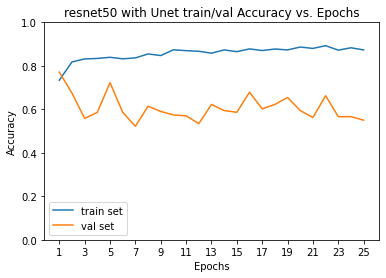

In [ ]:
# plotting the curve 
train_acc = []
val_acc = []

# train_acc_values , val_acc_values

train_acc = [h.cpu().numpy() for h in train_acc_values]
val_acc = [h.cpu().numpy() for h in val_acc_values]

plt.title("resnet50 with Unet train/val Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,26),train_acc,label="train set")
plt.plot(range(1,26),val_acc,label="val set")
plt.ylim((0,1.))
plt.xticks(np.arange(1, 26, 2.0))
plt.legend()
plt.show()

In [ ]:
def test_acc(model):
    model.eval()
    running_corrects = 0

    nb_classes = 2
    confusion_matrix = torch.zeros(nb_classes, nb_classes)

    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            mask,outputs = model(inputs) # unet
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            
            for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

            predlist=torch.cat([predlist,preds.view(-1).cpu()])
            lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

    sk_cm = sk_confusion_matrix(lbllist.numpy(), predlist.numpy())

    # testing_acc = running_corrects.double() / dataset_sizes['test']
    testing_acc = running_corrects.double() / dataset_sizes['val']
    return confusion_matrix , testing_acc ,sk_cm

In [ ]:
confusion_matrix , testing_acc ,sk_cm = test_acc(model_ft)
print(confusion_matrix, '\n', testing_acc, '\n',  sk_cm)

tensor([[202.,  48.],
        [ 16., 230.]]) 
 tensor(0.8710, device='cuda:0', dtype=torch.float64) 
 [[202  48]
 [ 16 230]]


Confusion matrix, without normalization
[[202  48]
 [ 16 230]]


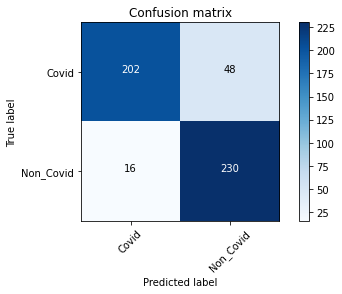

In [ ]:
plot_confusion_matrix(sk_cm, class_names)

In [ ]:
# import numpy as np
# sk_cm = np.array([[227 ,23],
#  [ 73 ,173]])

In [ ]:
# demo

tp = sk_cm[0][0]
tn = sk_cm[1][1]

# fp = sk_cm[0][1]
fn = sk_cm[0][1]

fp = sk_cm[1][0]
# fn = sk_cm[1][0]


precision = tp / (tp + fp)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
f1_score = (2*tp) / (2*tp + fp + fn)
# f1_score = (2*precision*sensitivity) / (precision+sensitivity)
accuracy = (tp+tn) / dataset_sizes['val']

print('Precision: {:.2f} %\n Sensitivity: {:.2f} %\n Specificity: {:.2f} %\n F1_scorer: {:.2f} %\n Accuracy: {:.2f} %'.format(precision*100, sensitivity*100, specificity*100, f1_score*100, accuracy*100))

Precision: 92.66 %
 Sensitivity: 80.80 %
 Specificity: 93.50 %
 F1_scorer: 86.32 %
 Accuracy: 87.10 %
